In [1]:
import pandas as pd
import numpy as np

In [2]:
file = pd.read_csv('Reviews.csv')

In [3]:
file.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
file['level'] = file['Score'].apply(lambda x: 1 if x>3 else 0 )

In [5]:
file['level'].head()

0    1
1    0
2    1
3    0
4    1
Name: level, dtype: int64

In [6]:
useful = file[['Text','level']]

In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [15]:
from keras.preprocessing.text import Tokenizer

C:\Users\ankur\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(useful['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 133039 unique tokens.


In [39]:
word_index['i']

2

In [20]:
from keras.preprocessing.sequence import pad_sequences

In [21]:
X = tokenizer.texts_to_sequences(useful['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (568454, 250)


In [7]:
from sklearn.model_selection import train_test_split

In [46]:
Y =  pd.get_dummies(useful['level'])

In [47]:
Y.head()

,0,1
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1


In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [38]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [30]:
useful['level'].shape

(568454,)

In [54]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 64



In [44]:
from keras.callbacks import EarlyStopping

In [55]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 258646 samples, validate on 110849 samples
Epoch 1/3
258646/258646 [==============================] - 1719s 7ms/step - loss: 0.2874 - acc: 0.8813 - val_loss: 0.2215 - val_acc: 0.9112
Epoch 2/3
258646/258646 [==============================] - 1930s 7ms/step - loss: 0.2030 - acc: 0.9199 - val_loss: 0.2394 - val_acc: 0.8999
Epoch 3/3
258646/258646 [==============================] - 1703s 7ms/step - loss: 0.1638 - acc: 0.9371 - val_loss: 0.1878 - val_acc: 0.9267


In [56]:
accr = model.evaluate(X_test,Y_test)
print('loss',accr[0])


198959/198959 [==============================] - 277s 1ms/step
loss 0.1875216156217765


NameError: name 'acc' is not defined

In [57]:
print('accuracy', accr[1])

accuracy 0.9264923929056701


In [59]:
import matplotlib.pyplot as plt

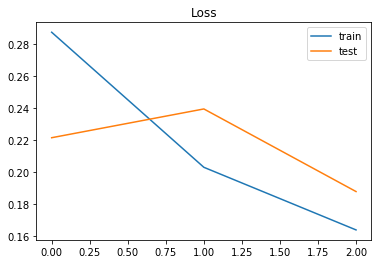

In [60]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

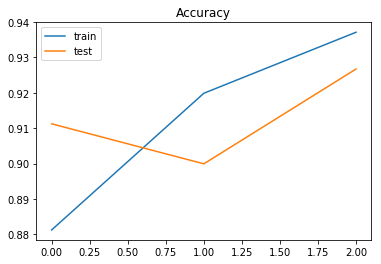

In [61]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [62]:
new_review = ['I am in love with this product. I mean it fits my needs perfectly. So glad']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

In [63]:
pred

array([[0.00220205, 0.99779797]], dtype=float32)

In [65]:
new_review = ['I hate this one, so bad , i cant believe all was lie']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
pred

array([[0.9866636 , 0.01333639]], dtype=float32)

In [67]:
new_review = ['I did not like it much, but it was not so bad']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
pred

array([[0.77057374, 0.2294263 ]], dtype=float32)

In [93]:
def output(review):
    seq = tokenizer.texts_to_sequences(review) # gives index of each word
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH) # Adds 0 upfront for missing words  
    pred = model.predict(padded)
    print( "positive prob: ",pred[0][1], ",negative prob  ",pred[0][0])

In [94]:
output(['I am in love with this product. I mean it fits my needs perfectly. So glad'])

positive prob:  0.99779797 ,negative prob   0.0022020484


In [81]:
output(['I hate this one, so bad , i cant believe all was lie'])

positive prob:  0.0133363865 ,negative prob   0.9866636


In [82]:
output(['I did not like it much, but it was not so bad'])

positive prob:  0.2294263 ,negative prob   0.77057374


In [84]:
output(['Somethings are good but few are average as well, i will it is say ok buy for this price'])

positive prob:  0.3266576 ,negative prob   0.6733424


In [103]:
s = 'abcfdfg'
s[::-3]

'gfa'

In [101]:
s[-1]

'g'